In [20]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline


f = open('data/names.txt', 'r')
words = f.read().split('\n')
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [21]:
b = {}
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

list(sorted(b.items(), key = lambda kv: -kv[1]))[:5]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983)]

In [22]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [23]:
N = torch.zeros((27, 27), dtype=torch.int32)

for w in words:
  chs = ['.'] + list(w) + ['.']
  for a, b in zip(chs, chs[1:]):
    ix1 = stoi[a]
    ix2 = stoi[b]
    N[ix1, ix2] += 1

In [ ]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
    plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis("off")

(-0.5, 26.5, 26.5, -0.5)

In [25]:
N[0]

In [26]:
# adding +1 here to apply model smoothing (no 0 counts)
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [27]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


In [28]:
# GOAL: maximize likelihood of data wrt model parameters (stat modeling)
# equiv to maximizing the log likelihood (because log is monotonic)
# equiv to minimizing the negative log likelihood
# equiv to minimizing the avg negative log likelihood


# log(a*b*c) = log(a) + log(b) = log(c)
log_likelihood = 0.0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for a, b in zip(chs, chs[1:]):
    ix1 = stoi[a]
    ix2 = stoi[b]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
avg_nll = nll/n
print(f'{avg_nll=}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
avg_nll=tensor(2.4544)


In [29]:
# create the training set of all of the bigrams (x,y)
# xs = inputs
# ys = targets (labels)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for a, b in zip(chs, chs[1:]):
    ix1 = stoi[a]
    ix2 = stoi[b]
    xs.append(ix1)
    ys.append(ix2)

# NB: not to be confused with torch.Tensor
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [30]:
import torch.nn.functional as F

In [31]:
# RANDOM WEIGHTS ---------------

In [32]:
# randomly initialize 27 neurons weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

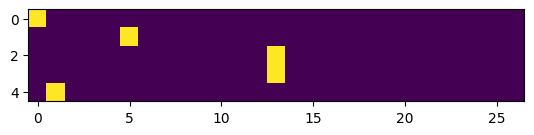

In [33]:
xenc = F.one_hot(xs, num_classes=27).float() # input to network with one-hot encoding
plt.imshow(xenc)

In [38]:
logits = xenc @ W # predict log-counts

# softmax activation function 
counts = logits.exp() # counts, equivalent to N above
probs = counts / counts.sum(1, keepdims=True) # probabilities for next char

In [39]:
probs.shape

torch.Size([5, 27])

In [40]:
# demonstrate starting loss
nlls = torch.zeros(5)
for i in range(5):
  x = xs[i].item() # input character idx
  y = ys[i].item() # label character idx (target)
  print('-----')
  print(f'bigram {i+1}: {itos[x]}{itos[y]} ({x}, {y})')
  print('input to neural net:', x)
  print('output probabilities from neural net:', probs[i])
  print('label (actual next character)', itos[y])
  p = probs[i, y]
  print('probability assigned for the correct character:', p.item())
  nll = -torch.log(p)
  print('negative log likelihood:', nll.item())
  nlls[i] = nll
print('======')
print('average negative log likelihood (loss):', nlls.mean().item())

-----
bigram 1: .e (0, 5)
input to neural net: 0
output probabilities from neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character) e
probability assigned for the correct character: 0.012286253273487091
negative log likelihood: 4.3992743492126465
-----
bigram 2: em (5, 13)
input to neural net: 5
output probabilities from neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character) m
probability assigned for the correct character: 0.018050702288746834
negative log likelihood: 4.014570713043213
-----
bigram 3: mm (13, 13)
input to neural net: 13
ou

In [372]:
# OPTIMIZE WEIGHTS ONCE ---------------

In [41]:
# randomly initialize 27 neurons weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [59]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean()

In [60]:
# backward pass
W.grad = None # set grads to zero
loss.backward()

In [61]:
W.data += -0.1 * W.grad

In [377]:
# OPTIMIZED WEIGHTS WITH GRADIENT DESCENT ---------------

In [62]:
# create dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for a, b in zip(chs, chs[1:]):
    ia = stoi[a]
    ib = stoi[b]
    xs.append(ia)
    ys.append(ib)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples:', num)

# initialize the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples: 228146


In [65]:
# gradient descent
for k in range(1000):
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc @ W
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(num), ys].log().mean()
  
  # backward pass
  W.grad = None # set grads to zero
  loss.backward()
  
  # update
  W.data += -50 * W.grad

In [66]:
print('final loss with above values:', loss.item())

final loss with above values: 2.4552249908447266


In [67]:
# SAMPLING ---------

g = torch.Generator().manual_seed(2147483647)
for i in range(5):
  out = []
  ix = 0
  while True:
      xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
      logits = xenc @ W
      counts = logits.exp()
      p = counts / counts.sum(1, keepdims=True)
      
      ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
      out.append(itos[ix])
      if ix == 0:
        break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
